<a href="https://colab.research.google.com/github/TehLedRed/SpringerManuscript/blob/main/Application_bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
!pip install ipython-autotime
%load_ext autotime
!pip install import-ipynb
import import_ipynb
from google.colab import output
output.clear()

time: 4.39 s (started: 2023-10-18 01:09:36 +00:00)


In [ ]:
%cd /content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
import nbCure

/content/drive/MyDrive/Mestrado/PCM/simulation/Negative binomial
importing Jupyter notebook from nbCure.ipynb
time: 1.93 s (started: 2023-10-18 01:09:55 +00:00)


# Load data and preprocessing

In [ ]:
dataTrain0 = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/data/trainSet.csv")[["delta", "time"]]  # n=280
dataTest = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/data/testSet.csv")[["delta", "time"]]

mri = np.load("/content/drive/MyDrive/Mestrado/PCM/data/mri.npz")
mriTrain = mri["train_images"]
mriTest = mri["test_images"]

time: 258 ms (started: 2023-10-16 23:32:27 +00:00)


Remove outlier and normalize images data.

In [ ]:
mriTrain = np.delete(mriTrain, 230, axis=0)

imgTrain0 = (mriTrain/2240).astype(np.float32)
imgTest = (mriTest/2240).astype(np.float32)

time: 74 ms (started: 2023-10-16 23:32:30 +00:00)


Generate bootstrap samples

In [ ]:
for i in range(1,101):
  sample = np.random.choice(280, 280)
  tab = pd.DataFrame(sample, columns=["i"])
  tab.to_csv("/content/drive/MyDrive/Mestrado/PCM/bootstrap/samples/sample" + str(i) + ".csv",  index=False)

time: 711 ms (started: 2023-10-16 23:51:47 +00:00)


# Auxiliary functions

### Susceptible individuals

1. Calculate $g$ interval times

In [ ]:
@tf.function
def calc_mat(t):
    '''
    Returns two matrices to be used later in alpha estimation, each matrix's
    shape equals to (#of indivuals x 5) as g = 5.
    '''
    g = tf.constant(
        [0.95342463, 2.06191778, 3.35999999, 4.49534245, 6.32000008, 12.2],
        shape=(1,6))
    t1 = t - g[:,:-1]
    t2  = g[:,1:] - g[:,:-1]

    indicator2 = t > g[:,1:]
    cat = tf.reduce_sum(tf.cast(indicator2, dtype=tf.float32), axis=1)
    indicator1 = tf.one_hot(tf.cast(cat, dtype=tf.int32), depth=5)

    num = indicator1
    denom = tf.add(indicator1*t1, indicator2*t2)

    return num, denom

time: 1.23 ms (started: 2023-10-18 01:10:07 +00:00)


### Accuracy metric - imputed AUC

In [ ]:
def aucFI(eta, phi):
  theta = np.exp(eta)

  if (phi==None):
    pc = np.exp(-theta)
  else:
    term = 1 + phi*theta
    pc = np.power(term, -(1/phi))

  seq = np.arange(0,1,0.01)
  TPR = []
  FPR = []

  for i in seq:
    TPR.append(np.sum(np.where(pc <= i, 1, 0) * (1-pc))/ np.sum(1-pc))
    FPR.append(np.sum(np.where(pc <= i, 1, 0) * pc)/ np.sum(pc))

  TPR = np.array(TPR)
  FPR = np.array(FPR)

  return np.sum((TPR[:-1] + TPR[1:])*(FPR[1:] - FPR[:-1])*0.5)

time: 1.17 ms (started: 2023-10-18 01:10:02 +00:00)


### Convolutional neural network

Subclassing keras.Model class

In [ ]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv2D(
            filters=4,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32
        )
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv2 = tf.keras.layers.Conv2D(
            filters=12,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32
        )
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)
        self.conv3 = tf.keras.layers.Conv2D(
            filters=32,
            kernel_size=[5, 5],
            padding="same",
            activation=tf.nn.leaky_relu,
            dtype=tf.float32
        )
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size=[2, 2], strides=2)

        self.flatten = tf.keras.layers.Reshape(target_shape=(-1,))
        self.dense2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh, dtype=tf.float32)
        self.dense3 = tf.keras.layers.Dense(dtype=tf.float32, units=1, activation=None, use_bias=False)

    def call(self, input_img):
        inputs = tf.reshape(input_img, [-1, 160, 200, 1])
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.dense2(x)

        return self.dense3(x)


time: 51.4 ms (started: 2023-10-17 00:04:24 +00:00)


### Quantiles

In [ ]:
def q1(x):
  return x.quantile(0.025)

def q2(x):
  return x.quantile(0.5)

def q3(x):
  return x.quantile(0.975)

time: 656 µs (started: 2023-10-18 01:12:00 +00:00)


# NB Model

In [ ]:
timeTest = tf.constant(dataTest.time, dtype=tf.float32, shape=[72,1])
deltaTest = tf.constant(dataTest.delta, dtype=tf.float32, shape=[72,1])
matNumTest, matDenomTest = calc_mat(timeTest)

time: 335 ms (started: 2023-10-17 00:12:29 +00:00)


## Run

In [ ]:
phi = 0.01
alphaHat = np.empty((0,5), int)
aucTrain = []
aucTest = []
for b in range(1, 101):

    sample_i = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/bootstrap/samples/sample" + str(b) + ".csv")
    index = sample_i["i"].to_numpy()

    dataTrain = dataTrain0.iloc[index,]
    imgTrain = imgTrain0[index]
    timeTrain = tf.constant(dataTrain.time, dtype=tf.float32, shape=[280,1])
    deltaTrain = tf.constant(dataTrain.delta, dtype=tf.float32, shape=[280,1])
    matNumTrain, matDenomTrain = calc_mat(timeTrain)

    model = Model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    mi = deltaTrain + 1e-2
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
    alpha_record = alpha.numpy().copy()
    S1 = nbCure.calc_S1(alpha, matDenomTrain)

    with tf.GradientTape() as tape:
      loss = nbCure.calcL1(mi, phi, model(imgTrain))
      print("initial loss %f" % (loss.numpy()))

    grads = tape.gradient(loss, sources = model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    var_list = []
    for l in range(len(model.variables)):
        var_list.append(tf.squeeze(model.variables[l]).numpy())
    var_record = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

    # second run ---------------------------------------------------
    eps = 1
    num_iter = 1

    while eps > 1e-6 and num_iter <= 30:
        min_loss = 10.
        early_stopping_at = 1
        count_patience = 0
        patience = 5

        # 1. first updating mi
        mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(imgTrain)), S1)

        # 2. updating alpha, S1
        alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
        S1 = nbCure.calc_S1(alpha, matDenomTrain)

        # calculations for test set
        S1_t = nbCure.calc_S1(alpha, matDenomTest)
        mi_t = nbCure.calcM(deltaTest, phi, tf.math.exp(model(imgTest)), S1_t)

        for epoch in range(1, 50):
            # 3. updating network parameters
            with tf.GradientTape() as tape:
                loss = nbCure.calcNBL1(mi, phi, model(imgTrain))
                loss_t = nbCure.calcNBL1(mi_t, phi, model(imgTest))

            if epoch % 250 == 0:
                print("# %d-%d: loss %4f, loss_t %4f" % (b, num_iter, loss.numpy(), loss_t.numpy()))

            grads = tape.gradient(loss, sources=model.variables)
            optimizer.apply_gradients(zip(grads, model.variables))

            # termination conditions
            if loss_t < min_loss:
                min_loss = loss_t.numpy().copy()
                early_stopping_at = epoch
                best_variable = model.variables
                count_patience = 0

            else:
                count_patience += 1

            if count_patience > patience:
                for i in range(len(model.variables)):
                    model.variables[i].assign(best_variable[i])
                break

        # 4. Record changes in losses
        var_list = []
        for l in range(len(model.variables)):
            var_list.append(tf.squeeze(model.variables[l]).numpy())
        var_new = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

        eps = np.mean((var_new - var_record)**2) + np.mean((alpha-alpha_record)**2)
        var_record = var_new.copy()
        alpha_record = alpha.numpy().copy()
        print("# %d-%d ε: %6f, early stops @E%d" % (b, num_iter, eps, early_stopping_at))

        # 5. iteration +1
        num_iter += 1

    # Update calcultations due to early stopping
    S1 = nbCure.calc_S1(alpha, matDenomTrain)
    mi = nbCure.calcM(deltaTrain, phi, tf.math.exp(model(imgTrain)), S1)
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)

    S1_t = nbCure.calc_S1(alpha, matDenomTest)
    mi_t = nbCure.calcM(deltaTest.numpy(), phi, tf.math.exp(model(imgTest)), S1_t)

    alphaHat = np.append(alphaHat, alpha.numpy().reshape(-1,5), axis=0)
    aucTrain.append(aucFI(model(imgTrain), phi))
    aucTest.append(aucFI(model(imgTest), phi))

    del model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    del mi, alpha, alpha_record, S1
    del mi_t, S1_t
    del best_variable, var_new, var_record



initial loss 1.640343


# 1-1 ε: 0.027277, early stops @E2
# 1-2 ε: 0.001707, early stops @E10
# 1-3 ε: 0.000003, early stops @E1
# 1-4 ε: 0.000048, early stops @E9
# 1-5 ε: 0.000039, early stops @E10
# 1-6 ε: 0.000063, early stops @E5
# 1-7 ε: 0.000072, early stops @E3
# 1-8 ε: 0.000082, early stops @E2
# 1-9 ε: 0.000142, early stops @E3
# 1-10 ε: 0.000353, early stops @E2
# 1-11 ε: 0.000305, early stops @E2
# 1-12 ε: 0.000131, early stops @E2
# 1-13 ε: 0.000073, early stops @E2
# 1-14 ε: 0.000187, early stops @E2
# 1-15 ε: 0.000101, early stops @E2
# 1-16 ε: 0.002090, early stops @E2
# 1-17 ε: 0.000326, early stops @E1
# 1-18 ε: 0.000155, early stops @E3
# 1-19 ε: 0.000360, early stops @E2
# 1-20 ε: 0.000402, early stops @E2
# 1-21 ε: 0.000285, early stops @E2
# 1-22 ε: 0.000382, early stops @E1
# 1-23 ε: 0.003277, early stops @E1
# 1-24 ε: 0.000209, early stops @E1
# 1-25 ε: 0.000210, early stops @E1
# 1-26 ε: 0.000101, early stops @E1
# 1-27 ε: 0.000004, early stops @E1
# 1-28 ε: 0.000007, early stops @E1

## Result

In [ ]:
D1 = pd.DataFrame(aucTrain, columns = ["aucTrain"])
D2 = pd.DataFrame(aucTest, columns = ["auctest"])
D3 = pd.DataFrame(alphaHat, columns = range(1,6))
resNB = pd.concat([D1, D2, D3], axis = 1)

resNB.to_csv("/content/drive/MyDrive/Mestrado/PCM/bootstrap/100loops_nb.csv", index=False)
resNB

time: 11.9 ms (started: 2023-10-17 01:50:41 +00:00)


In [ ]:
resStatNB = resNB.agg(['mean', 'std', q1, q2, q3])
resStatNB

,aucTrain,auctest,1,2,3,4,5
mean,0.832066,0.781006,0.048659,0.070641,0.133353,0.181767,0.588516
std,0.059323,0.049832,0.023333,0.029389,0.058779,0.057860,0.201634
q1,0.709700,0.680361,0.017370,0.027592,0.052378,0.084563,0.321970
q2,0.850377,0.792656,0.046545,0.064515,0.118985,0.188655,0.542635
q3,0.895008,0.844128,0.111836,0.130714,0.277550,0.304864,1.079108


time: 47.9 ms (started: 2023-10-18 01:12:09 +00:00)


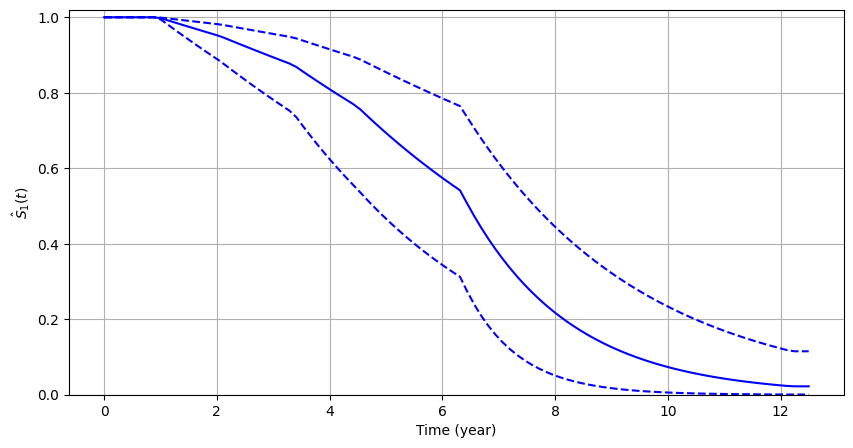

time: 3.51 s (started: 2023-10-18 01:13:11 +00:00)


In [ ]:
seqT = np.linspace(0, 12.5, 100)
matSeq = calc_mat(np.array(seqT, dtype=np.float32).reshape(-1,1))[1]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.set(ylim=(0, 1.02))
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q2","1":"5"], matSeq), color="b", linestyle="-")
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q1","1":"5"], matSeq), color="b", linestyle="--")
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q3","1":"5"], matSeq), color="b", linestyle="--")
ax.grid(True)
ax.set_ylabel(r'$\hat{S}_1(t)$')
ax.set_xlabel('Time (year)')
plt.show()

# Poisson model

In [ ]:
def calcPCML1(mi, theta):
  return -tf.reduce_mean(mi*theta - tf.exp(theta))

time: 610 µs (started: 2023-10-17 01:54:00 +00:00)


## Run

In [ ]:
alphaHat = np.empty((0,5), int)
aucTrain = []
aucTest = []
for b in range(1, 101):

    sample_i = pd.read_csv("/content/drive/MyDrive/Mestrado/PCM/bootstrap/samples/sample" + str(b) + ".csv")
    index = sample_i["i"].to_numpy()

    dataTrain = dataTrain0.iloc[index,]
    imgTrain = imgTrain0[index]
    timeTrain = tf.constant(dataTrain.time, dtype=tf.float32, shape=[280,1])
    deltaTrain = tf.constant(dataTrain.delta, dtype=tf.float32, shape=[280,1])
    matNumTrain, matDenomTrain = calc_mat(timeTrain)

    model = Model()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    mi = deltaTrain + 1e-2
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
    alpha_record = alpha.numpy().copy()
    S1 = nbCure.calc_S1(alpha, matDenomTrain)

    with tf.GradientTape() as tape:
      loss = calcPCML1(mi, model(imgTrain))
      print("initial loss %f" % (loss.numpy()))

    grads = tape.gradient(loss, sources = model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    var_list = []
    for l in range(len(model.variables)):
        var_list.append(tf.squeeze(model.variables[l]).numpy())
    var_record = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

    # second run ---------------------------------------------------
    eps = 1
    num_iter = 1

    while eps > 1e-6 and num_iter <= 30:
        min_loss = 10.
        early_stopping_at = 1
        count_patience = 0
        patience = 5

        # 1. first updating mi
        mi = tf.exp(model(imgTrain))*S1 + deltaTrain

        # 2. updating alpha, S1
        alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)
        S1 = nbCure.calc_S1(alpha, matDenomTrain)

        # calculations for test set
        S1_t = nbCure.calc_S1(alpha, matDenomTest)
        mi_t = tf.exp(model(imgTest))*S1_t + deltaTest

        for epoch in range(1, 50):
            # 3. updating network parameters
            with tf.GradientTape() as tape:
                loss = calcPCML1(mi, model(imgTrain))
                loss_t = calcPCML1(mi_t, model(imgTest))

            if epoch % 250 == 0:
                print("# %d-%d: loss %4f, loss_t %4f" % (b, num_iter, loss.numpy(), loss_t.numpy()))

            grads = tape.gradient(loss, sources=model.variables)
            optimizer.apply_gradients(zip(grads, model.variables))

            # termination conditions
            if loss_t < min_loss:
                min_loss = loss_t.numpy().copy()
                early_stopping_at = epoch
                best_variable = model.variables
                count_patience = 0

            else:
                count_patience += 1

            if count_patience > patience:
                for i in range(len(model.variables)):
                    model.variables[i].assign(best_variable[i])
                break

        # 4. Record changes in losses
        var_list = []
        for l in range(len(model.variables)):
            var_list.append(tf.squeeze(model.variables[l]).numpy())
        var_new = np.concatenate(list(map(lambda x: x.reshape(-1), var_list))).copy()

        eps = np.mean((var_new - var_record)**2) + np.mean((alpha-alpha_record)**2)
        var_record = var_new.copy()
        alpha_record = alpha.numpy().copy()
        print("# %d-%d ε: %6f, early stops @E%d" % (b, num_iter, eps, early_stopping_at))

        # 5. iteration +1
        num_iter += 1

    # Update calcultations due to early stopping
    S1 = nbCure.calc_S1(alpha, matDenomTrain)
    mi = tf.exp(model(imgTrain))*S1 + deltaTrain
    alpha = nbCure.calc_alpha(mi, deltaTrain, matNumTrain, matDenomTrain)

    S1_t = nbCure.calc_S1(alpha, matDenomTest)
    mi_t = tf.exp(model(imgTest))*S1_t + deltaTest

    alphaHat = np.append(alphaHat, alpha.numpy().reshape(-1,5), axis=0)
    aucTrain.append(aucFI(model(imgTrain), phi = None))
    aucTest.append(aucFI(model(imgTest), phi = None))

    del model
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()
    del mi, alpha, alpha_record, S1
    del mi_t, S1_t
    del best_variable, var_new, var_record



initial loss 0.976054
# 1-1 ε: 0.011078, early stops @E1
# 1-2 ε: 0.005925, early stops @E13
# 1-3 ε: 0.000936, early stops @E12
# 1-4 ε: 0.000125, early stops @E9
# 1-5 ε: 0.000048, early stops @E6
# 1-6 ε: 0.000137, early stops @E4
# 1-7 ε: 0.000297, early stops @E3
# 1-8 ε: 0.000152, early stops @E3
# 1-9 ε: 0.000023, early stops @E3
# 1-10 ε: 0.000033, early stops @E3
# 1-11 ε: 0.000049, early stops @E2
# 1-12 ε: 0.000112, early stops @E2
# 1-13 ε: 0.000012, early stops @E3
# 1-14 ε: 0.000142, early stops @E2
# 1-15 ε: 0.000078, early stops @E2
# 1-16 ε: 0.001085, early stops @E8
# 1-17 ε: 0.000568, early stops @E4
# 1-18 ε: 0.000057, early stops @E3
# 1-19 ε: 0.000014, early stops @E3
# 1-20 ε: 0.000182, early stops @E2
# 1-21 ε: 0.000590, early stops @E1
# 1-22 ε: 0.002192, early stops @E1
# 1-23 ε: 0.000695, early stops @E16
# 1-24 ε: 0.000083, early stops @E1
# 1-25 ε: 0.000104, early stops @E1
# 1-26 ε: 0.000061, early stops @E1
# 1-27 ε: 0.000011, early stops @E2
# 1-28 ε: 0.

## Result

In [ ]:
D1 = pd.DataFrame(aucTrain, columns = ["aucTrain"])
D2 = pd.DataFrame(aucTest, columns = ["auctest"])
D3 = pd.DataFrame(alphaHat, columns = range(1,6))
res = pd.concat([D1, D2, D3], axis = 1)

res.to_csv("/content/drive/MyDrive/Mestrado/PCM/bootstrap/100loops_pcm.csv", index=False)
res

,aucTrain,auctest,1,2,3,4,5
0,0.754630,0.775768,0.102842,0.062918,0.247582,0.277739,0.742029
1,0.865557,0.809819,0.132277,0.255873,0.109271,0.311161,0.620066
2,0.829604,0.756727,0.063923,0.061077,0.241317,0.165779,0.846908
3,0.864390,0.800940,0.019010,0.012911,0.049953,0.112835,0.220731
4,0.690057,0.743564,0.069834,0.085057,0.092892,0.151333,0.678896
...,...,...,...,...,...,...,...
95,0.810125,0.794278,0.035858,0.064958,0.139635,0.106988,0.556846
96,0.871761,0.763736,0.032590,0.046117,0.062317,0.109682,0.450148
97,0.882642,0.827191,0.063787,0.124853,0.327422,0.223307,0.690670
98,0.884195,0.825932,0.025503,0.057869,0.116212,0.082694,0.285531


time: 27.8 ms (started: 2023-10-17 03:04:44 +00:00)


In [ ]:
resStat = res.agg(['mean', 'std', q1, q2, q3])
resStat

,aucTrain,auctest,1,2,3,4,5
mean,0.831481,0.783034,0.050816,0.073376,0.135361,0.184000,0.589287
std,0.063529,0.049128,0.025328,0.037387,0.059180,0.059353,0.202318
q1,0.667735,0.660349,0.016570,0.029967,0.049733,0.083310,0.287260
q2,0.848589,0.792627,0.047271,0.065014,0.123469,0.187220,0.572247
q3,0.898700,0.845525,0.115514,0.175137,0.293136,0.301436,1.065154


time: 38.2 ms (started: 2023-10-17 03:04:52 +00:00)


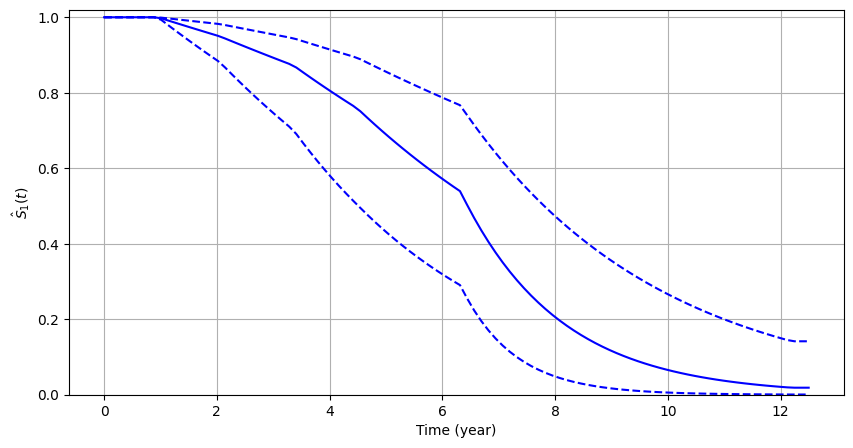

time: 231 ms (started: 2023-10-18 01:14:47 +00:00)


In [ ]:
seqT = np.linspace(0, 12.5, 100)
matSeq = calc_mat(np.array(seqT, dtype=np.float32).reshape(-1,1))[1]

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.set(ylim=(0, 1.02))
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q2","1":"5"], matSeq), color="b", linestyle="-")
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q1","1":"5"], matSeq), color="b", linestyle="--")
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q3","1":"5"], matSeq), color="b", linestyle="--")
ax.grid(True)
ax.set_ylabel(r'$\hat{S}_1(t)$')
ax.set_xlabel('Time (year)')
plt.show()

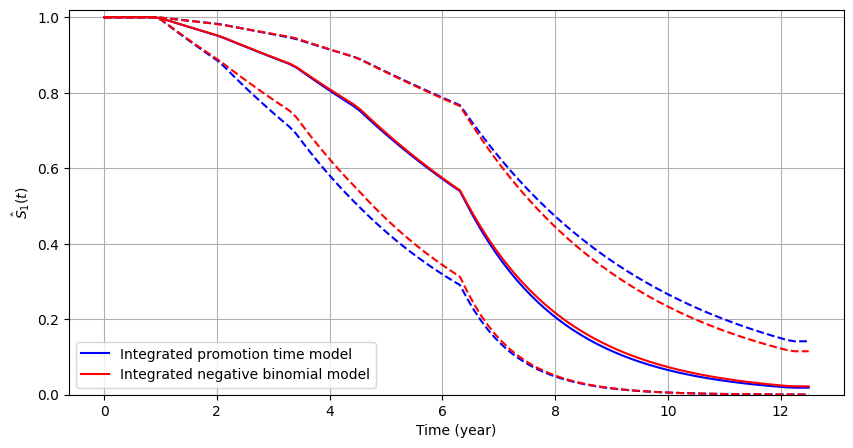

time: 421 ms (started: 2023-10-18 01:16:00 +00:00)


In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
ax.set(ylim=(0, 1.02))
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q2","1":"5"], matSeq), color="b", linestyle="-", label = 'Integrated promotion time model')
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q1","1":"5"], matSeq), color="b", linestyle="--")
ax.plot(seqT, nbCure.calc_S1(resStat.loc["q3","1":"5"], matSeq), color="b", linestyle="--")
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q2","1":"5"], matSeq), color="r", linestyle="-", label = 'Integrated negative binomial model')
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q1","1":"5"], matSeq), color="r", linestyle="--")
ax.plot(seqT, nbCure.calc_S1(resStatNB.loc["q3","1":"5"], matSeq), color="r", linestyle="--")
ax.grid(True)
ax.set_ylabel(r'$\hat{S}_1(t)$')
ax.set_xlabel('Time (year)')
ax.legend(loc = 'lower left')
plt.show()

Text(0.5, 1.0, 'AUC')

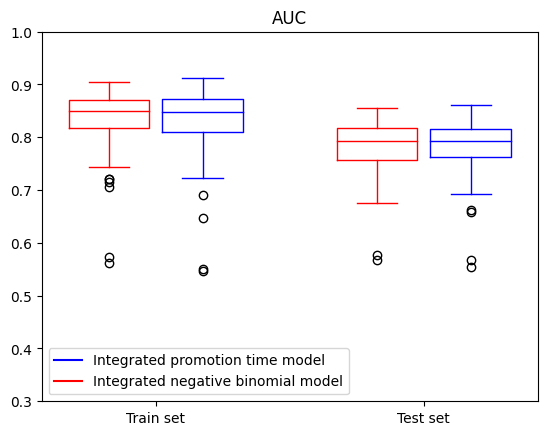

time: 718 ms (started: 2023-10-18 02:00:26 +00:00)


In [ ]:
# create 2 - sample a 3-Dim array, that measures
# the pcm and nb fall amount
train_auc = [resNB["aucTrain"], resNB["auctest"]]
test_auc = [res["aucTrain"], res["auctest"]]

# the list named ticks, summarizes or groups
# the pcm and nbfall as low, mid
# and high
ticks = ['Train set', 'Test set']

# create a boxplot for two arrays separately,
# the position specifies the location of the
# particular box in the graph,
# this can be changed as per your wish. Use width
# to specify the width of the plot
train_auc_plot = plt.boxplot(train_auc,
							positions=np.array(
	np.arange(len(train_auc)))*2.0-0.35,
							widths=0.6)
test_auc_plot = plt.boxplot(test_auc,
							positions=np.array(
	np.arange(len(test_auc)))*2.0+0.35,
							widths=0.6)

# each plot returns a dictionary, use plt.setp()
# function to assign the color code
# for all properties of the box plot of particular group
# use the below function to set color for particular group,
# by iterating over all properties of the box plot
def define_box_properties(plot_name, color_code, label):
	for k, v in plot_name.items():
		plt.setp(plot_name.get(k), color=color_code)

	# use plot function to draw a small line to name the legend.
	plt.plot([], c=color_code, label=label)
	plt.legend()


# setting colors for each groups

define_box_properties(test_auc_plot, 'b', 'Integrated promotion time model')
define_box_properties(train_auc_plot, 'r', 'Integrated negative binomial model')

# set the x label values
plt.xticks(np.arange(0, len(ticks) * 2, 2), ticks)
plt.legend(loc = 'lower left')
# set the limit for x axis
# plt.xlim(-2, len(ticks)*2)

# # set the limit for y axis
plt.ylim(0.3, 1.0)

# set the title
plt.title('AUC')
